# 通过极简方案构建手写数字识别模型

上一节介绍了创新性的“横纵式”教学法，有助于深度学习初学者快速掌握深度学习理论知识，并在过程中让读者获得真实建模的实战体验。在“横纵式”教学法中，纵向概要介绍模型的基本代码结构和极简实现方案，如 **图1** 所示。本节将使用这种极简实现方案快速完成手写数字识别的建模。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/c2cf4bf3c5f446b6831f7d702896ed4e615782b27a244dc9a8de0f3af7cca831" width="800" hegiht="" ></center>
<center><br>图1：“横纵式”教学法—纵向极简实现方案</br></center>
<br></br>

### 前提条件

在数据处理前，首先要加载飞桨平台与“手写数字识别”模型相关的类库，实现方法如下。

In [ ]:
!python3 -m pip --version # 查看pip版本
!python -m pip install --upgrade pip #更新pip版本
!python -m pip install paddlepaddle==1.7.2 -i https://mirror.baidu.com/pypi/simple #下载paddle1.8.5版本
!python -m pip install paddlepaddle==2.0.1 -i https://mirror.baidu.com/pypi/simple
# !pip install PIL

pip 19.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
     |████████████████████████████████| 1.5MB 10.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 103.3 MB 61 kB/s 
     |████████████████████████████████| 25.2 MB 9.3 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 208.1 MB 49 kB/s 
  Attempting uninstall: paddlepaddle
    Found

In [ ]:
#加载飞桨和相关类库
import paddle
import paddle.fluid as fluid
from paddle.fluid.dygraph.nn import Linear
import numpy as np
import os
from PIL import Image

# 数据处理

飞桨提供了多个封装好的数据集API，涵盖计算机视觉、自然语言处理、推荐系统等多个领域，帮助读者快速完成机器学习任务。如在手写数字识别任务中，通过[paddle.dataset.mnist.train()](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/data_cn/dataset_cn/mnist_cn.html#paddle-dataset-mnist-train)可以直接获取处理好的MNIST训练集、验证集和测试集，飞桨API支持如下常见的学术数据集：

* mnist
* cifar
* Conll05
* imdb
* imikolov
* movielens
* sentiment
* uci_housing
* wmt14
* wmt16

通过paddle.dataset.mnist.train()函数设置数据读取器，``batch_size``设置为8，即一个批次有8张图片和8个标签，代码如下所示。

In [ ]:
# 如果～/.cache/paddle/dataset/mnist/目录下没有MNIST数据，API会自动将MINST数据下载到该文件夹下
# 设置数据读取器，读取MNIST数据训练集
trainset = paddle.dataset.mnist.train()
# 包装数据读取器，每次读取的数据数量设置为batch_size=8，8个图片作为一个训练批次
train_reader = paddle.batch(trainset, batch_size=8)

Cache file /root/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /root/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished


``paddle.batch``函数将MNIST数据集拆分成多个批次，通过如下代码读取第一个批次的数据内容，观察数据打印结果。


图像数据形状和对应数据为: (8, 784) [-1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -1.         -1.         -1.         -1.         -1.         -1.
 -

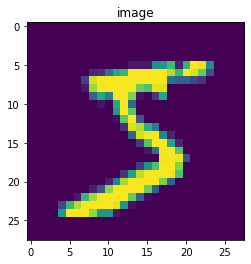

In [ ]:
# 以迭代的形式读取数据
for batch_id, data in enumerate(train_reader()):
    # 获得图像数据，并转为float32类型的数组
    img_data = np.array([x[0] for x in data]).astype('float32')
    # 获得图像标签数据，并转为float32类型的数组
    label_data = np.array([x[1] for x in data]).astype('float32')
    # 打印数据形状
    print("图像数据形状和对应数据为:", img_data.shape, img_data[0])
    print("图像标签形状和对应数据为:", label_data.shape, label_data[0])
    break

print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(label_data[0]))
# 显示第一batch的第一个图像
import matplotlib.pyplot as plt
img = np.array(img_data[0]+1)*127.5
img = np.reshape(img, [28, 28]).astype(np.uint8)

plt.figure("Image") # 图像窗口名称
plt.imshow(img)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

从打印结果看，从数据加载器``train_reader()``中读取一次数据，可以得到形状为（8, 784）的图像数据和形状为（8,）的标签数据。其中，形状中的数字8与设置的``batch_size``大小对应，784为MINIST数据集中每个图像的像素大小(28\*28)。

此外，从打印的图像数据来看，图像数据的范围是[-1, 1]，表明这是已经完成图像归一化后的图像数据，并且空白背景部分的值是-1。将图像数据反归一化，并使用matplotlib工具包将其显示出来，如 **图2** 所示。图片显示的数字是5，和对应标签数字一致。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/a07d9b3b5839434e98afe05a298d3ce1c9b6cbc02124488a9bd8b7c2efeb42c4" width="300" hegiht="" ></center>
<center><br>图2：matplotlib打印结果示意图</br></center>
<br></br>

------
**说明：**

飞桨将维度是28\*28的手写数字图像转成向量形式存储，因此使用飞桨数据加载器读取到的手写数字图像是长度为784（28\*28）的向量。

------

## 飞桨API的使用方法

熟练掌握飞桨API的使用方法，是使用飞桨完成各类深度学习任务的基础，也是开发者必须掌握的技能，下面介绍飞桨API获取方式和使用方法。

**1. 飞桨API文档获取方式**

登录“[飞桨官网->文档->API Reference](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/index_cn.html)”，获取飞桨API文档，如 **图3** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/0c96809a781642b39dfefcd818322b65ff2d4f0206084a93800343c36e7f972d" width="700" hegiht="" ></center>
<center><br>图3：飞桨API文档</br></center>
<br></br>

**2. 通过搜索和分类浏览两种方式查阅API文档**

如果用户知道需要查阅的API名称，可通过页面右上角的**搜索框**，快速获取API。

如果想全面了解飞桨API文档内容，也可以在**API Reference**首页，单击“**API功能分类**”，通过概念分类获取不同职能的API，如 **图4** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/d88f845f00324232b2e6ceeaa711f84417e3a21d63724e2fa1ff997f4534e3a9" width="700" hegiht="" ></center>
<center><br>图4：飞桨API功能分类页面</br></center>
<br></br>

在API功能分类的页面，读者可以根据神经网络建模的逻辑概念来浏览相应部分的API，如优化器、网络层、评价指标、模型保存和加载等。

**3. API文档使用方法**

飞桨每个API的文档结构一致，包含接口形式、功能说明和计算公式、参数和返回值、代码示例四个部分。 以abs函数为例，API文档结构如 **图5** 所示。通过飞桨API文档，读者不仅可以详细查看函数功能，还可以通过可运行的代码示例来实践API的使用。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/377e2c082e6640f79fae460ce50161a27913ce7570ea4c0ab5be899b9fd5599f" width="600" hegiht="" ></center>
<center><br>图5：abs函数的API文档</br></center>
<br></br>


# 模型设计

在房价预测深度学习任务中，我们使用了单层且没有非线性变换的模型，取得了理想的预测效果。在手写数字识别中，我们依然使用这个模型预测输入的图形数字值。其中，模型的输入为784维（28\*28）数据，输出为1维数据，如 **图6** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/608fd0fdb4cb4eaf95bc1a2a27a5887ce0af06dc0b5e4d04ada8f8f324c9132e" width="400" hegiht="" ></center>
<center><br>图6：手写数字识别网络模型</br></center>
<br></br>

输入像素的位置排布信息对理解图像内容非常重要（如将原始尺寸为28\*28图像的像素按照7\*112的尺寸排布，那么其中的数字将不可识别），因此网络的输入设计为28\*28的尺寸，而不是1\*784，以便于模型能够正确处理像素之间的空间信息。

------
**说明：**

事实上，采用只有一层的简单网络（对输入求加权和）时并没有处理位置关系信息，因此可以猜测出此模型的预测效果可能有限。在后续优化环节介绍的卷积神经网络则更好的考虑了这种位置关系信息，模型的预测效果也会有显著提升。

------

下面以类的方式组建手写数字识别的网络，实现方法如下所示。

In [ ]:
# 定义mnist数据识别网络结构，同房价预测网络
class MNIST(fluid.dygraph.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        
        # 定义一层全连接层，输出维度是1，激活函数为None，即不使用激活函数
        self.fc = Linear(input_dim=784, output_dim=1, act=None)
        
    # 定义网络结构的前向计算过程
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

# 训练配置

训练配置需要先生成模型实例（设为“训练”状态），再设置优化算法和学习率（使用随机梯度下降SGD，学习率设置为0.01），实现方法如下所示。

In [ ]:
# 定义飞桨动态图工作环境
with fluid.dygraph.guard():
    # 声明网络结构
    model = MNIST()
    # 启动训练模式
    model.train()
    # 定义数据读取函数，数据读取batch_size设置为16
    train_loader = paddle.batch(paddle.dataset.mnist.train(), batch_size=16)
    # 定义优化器，使用随机梯度下降SGD优化器，学习率设置为0.01
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.01, parameter_list=model.parameters())

# 训练过程

训练过程采用二层循环嵌套方式，训练完成后需要保存模型参数，以便后续使用。

- 内层循环：负责整个数据集的一次遍历，遍历数据集采用分批次（batch）方式。
- 外层循环：定义遍历数据集的次数，本次训练中外层循环10次，通过参数EPOCH_NUM设置。

In [ ]:
# 通过with语句创建一个dygraph运行的context
# 动态图下的一些操作需要在guard下进行
with fluid.dygraph.guard():
    model = MNIST()
    model.train()
    train_loader = paddle.batch(paddle.dataset.mnist.train(), batch_size=16)
    optimizer = fluid.optimizer.SGDOptimizer(learning_rate=0.001, parameter_list=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):  #执行多少轮
        for batch_id, data in enumerate(train_loader()): #没轮下执行多少批次
            #准备数据，格式需要转换成符合框架要求的
            image_data = np.array([x[0] for x in data]).astype('float32')
            label_data = np.array([x[1] for x in data]).astype('float32').reshape(-1, 1)
            # 将数据转为飞桨动态图格式
            image = fluid.dygraph.to_variable(image_data)
            label = fluid.dygraph.to_variable(label_data)
            
            #前向计算的过程，predict预测值
            predict = model(image)
            
            #计算损失，取一个批次样本损失的平均值
            loss = fluid.layers.square_error_cost(predict, label)
            avg_loss = fluid.layers.mean(loss)
            
            #每训练了1000批次的数据，打印下当前Loss的情况
            if batch_id !=0 and batch_id  % 1000 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            optimizer.minimize(avg_loss)
            model.clear_gradients()

    # 保存模型
    fluid.save_dygraph(model.state_dict(), 'mnist')

epoch: 0, batch: 1000, loss is: [1.7364706]
epoch: 0, batch: 2000, loss is: [3.8565145]
epoch: 0, batch: 3000, loss is: [3.8248467]
epoch: 1, batch: 1000, loss is: [1.7408359]
epoch: 1, batch: 2000, loss is: [3.7984757]
epoch: 1, batch: 3000, loss is: [3.583038]
epoch: 2, batch: 1000, loss is: [1.7537904]


通过观察上述代码可以发现，手写数字识别的代码几乎与房价预测任务一致，如果不是下述读取数据的两行代码有所差异，我们会误认为这是房价预测的模型。

```
   #准备数据，格式需要转换成符合框架要求的
   image_data = np.array([x[0] for x in data]).astype('float32')
   label_data = np.array([x[1] for x in data]).astype('float32').reshape(-1, 1)
```


另外，从训练过程中损失所发生的变化可以发现，虽然损失整体上在降低，但到训练的最后一轮，损失函数值依然较高。可以猜测手写数字识别完全复用房价预测的代码，训练效果并不好。接下来我们通过模型测试，获取模型训练的真实效果。

# 模型测试

模型测试的主要目的是验证训练好的模型是否能正确识别出数字，包括如下四步：

* **声明实例**
* **加载模型**：加载训练过程中保存的模型参数，
* **灌入数据**：将测试样本传入模型，模型的状态设置为校验状态（eval），告诉框架我们接下来只会使用前向计算的流程，不会计算梯度和梯度反向传播。
* **获取预测结果，取整后作为预测标签输出**。

在模型测试之前，需要先从'./example_0.jpg'文件中读取样例图片，并进行归一化处理。

In [ ]:
# 导入图像读取第三方库
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# 读取图像
example = mpimg.imread('./example_0.png')
# 显示图像
plt.imshow(example)

In [ ]:
# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    print(np.array(im))
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, -1).astype(np.float32)
    # 图像归一化，保持和数据集的数据范围一致
    im = 1 - im / 127.5
    return im

# 定义预测过程
with fluid.dygraph.guard():
    # 模型声明
    model = MNIST()
    params_file_path = 'mnist'
    img_path = './example_0.png'
# 加载模型参数
    model_dict, _ = fluid.load_dygraph("mnist")
    model.load_dict(model_dict)
# 灌入数据
    model.eval()
    tensor_img = load_image(img_path)
    result = model(fluid.dygraph.to_variable(tensor_img))
#  预测输出取整，即为预测的数字，打印结果
    print("本次预测的数字是", result.numpy().astype('int32'))

从打印结果来看，模型预测出的数字与图片实际的数字不一致。这里只是验证了一个样本的情况，如果我们尝试更多的样本，可发现许多数字图片识别结果是错误的。因此完全复用房价预测的实验并不适用于手写数字识别任务！

接下来我们会对手写数字识别实验模型进行逐一改进，直到获得令人满意的结果。

## 作业 2-1：

1. 使用飞桨API [paddle.dataset.mnist](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/data_cn/dataset_cn/mnist_cn.html#paddle-dataset-mnist-test)的test函数获得测试集数据，计算当前模型的准确率。

2. 怎样进一步提高模型的准确率？可以在接下来内容开始前，写出你想到的优化思路。